In [2]:
%matplotlib inline
import os, os.path
import itertools
import pickle
import time
import numpy as np
import pandas as pd
from pyramid.arima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.stats import describe
import warnings

In [136]:
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

In [4]:
df_train = pd.read_csv('../train.csv/train.csv', parse_dates=['date'])
df_test = pd.read_csv('../test.csv/test.csv', parse_dates=['date'])
sample_sub= pd.read_csv('../sample_submission.csv')  

In [137]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0


In [139]:
def expand_df(df):
    data = df.copy()
    data['dayofmonth'] = data.date.dt.day
    data['dayofyear'] = data.date.dt.dayofyear
    data['dayofweek'] = data.date.dt.dayofweek
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['weekofyear'] = data.date.dt.weekofyear
    data['is_month_start'] = (data.date.dt.is_month_start).astype(int)
    data['is_month_end'] = (data.date.dt.is_month_end).astype(int)
    #df.sort_values(by=['store','item','date'], axis=0, inplace=True)
    return data
df_train['sales'] = df_train['sales'] * 1.0
data = expand_df(df_train)


grand_avg = data.sales.mean()
print(f"The grand average of sales in this dataset is {grand_avg:.4f}")
data.head()

The grand average of sales in this dataset is 52.2503


,date,store,item,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,2013,1,1,0
1,2013-01-02,1,1,11.0,2,2,2,1,2013,1,0,0
2,2013-01-03,1,1,14.0,3,3,3,1,2013,1,0,0
3,2013-01-04,1,1,13.0,4,4,4,1,2013,1,0,0
4,2013-01-05,1,1,10.0,5,5,5,1,2013,1,0,0


# changes by year

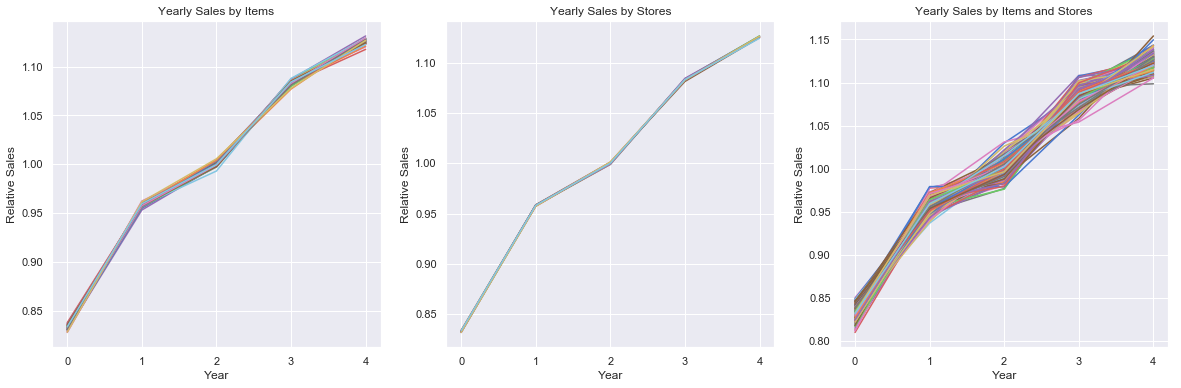

In [74]:
agg_year_item = pd.pivot_table(data, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(data, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values
agg_year_item_store = pd.pivot_table(data, index='year', columns=['item','store'],
                                values='sales', aggfunc=np.mean).values



#print(np.arange(2013, 2018))
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.xticks(range(0,5))
plt.title("Yearly Sales by Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")


plt.subplot(132)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.xticks(range(0,5))
plt.title("Yearly Sales by Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")

plt.subplot(133)
plt.plot(agg_year_item_store / agg_year_item_store.mean(0)[np.newaxis])
plt.xticks(range(0,5))
plt.title("Yearly Sales by Items and Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

# changes by month

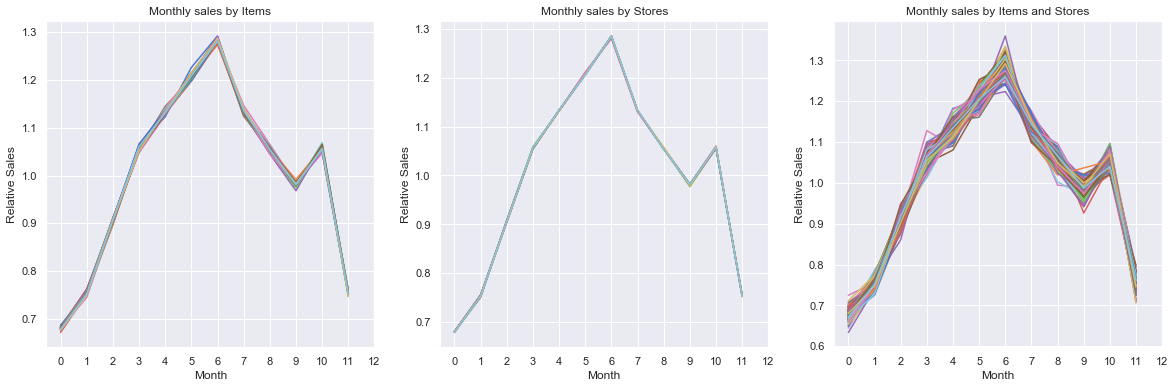

In [70]:
agg_month_item = pd.pivot_table(data, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(data, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values
agg_month_item_store = pd.pivot_table(data, index='month', columns=['item','store'],
                                 values='sales', aggfunc=np.mean).values
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.xticks(range(0,13))
plt.title("Monthly sales by Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.xticks(range(0,13))
plt.title("Monthly sales by Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_month_item_store / agg_month_item_store.mean(0)[np.newaxis])
plt.xticks(range(0,13))
plt.title("Monthly sales by Items and Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")

plt.show()

# change by dayofweek

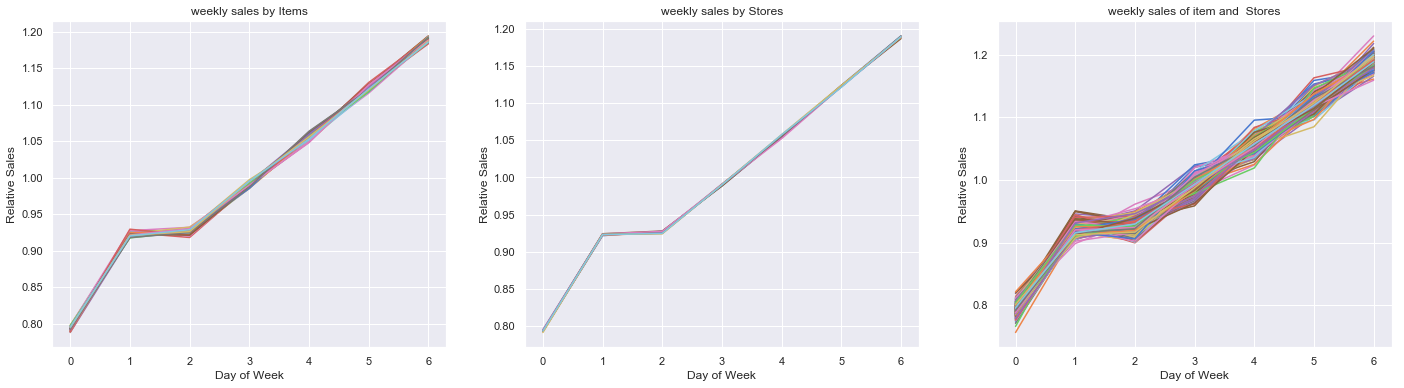

In [21]:
agg_dow_item = pd.pivot_table(data, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(data, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values
agg_dow_item_store = pd.pivot_table(data, index='dayofweek', columns=['item','store'],
                              values='sales', aggfunc=np.mean).values
plt.figure(figsize=(24, 6))
plt.subplot(131)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("weekly sales by Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("weekly sales by Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_dow_item_store / agg_dow_item_store.mean(0)[np.newaxis])
plt.title("weekly sales of item and  Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

# check week of year

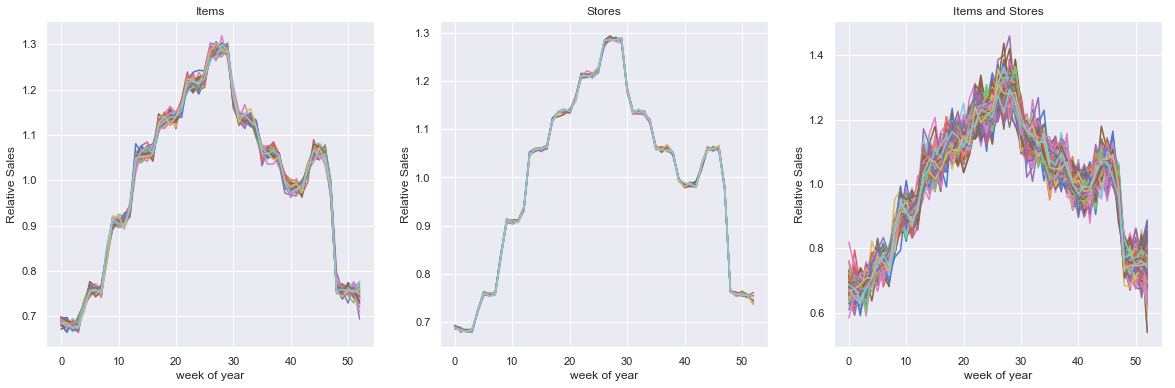

In [30]:
agg_woy_item = pd.pivot_table(data, index='weekofyear', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_woy_store = pd.pivot_table(data, index='weekofyear', columns='store',
                               values='sales', aggfunc=np.mean).values
agg_woy_item_store = pd.pivot_table(data, index='weekofyear', columns=['item','store'],
                               values='sales', aggfunc=np.mean).values
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.plot(agg_woy_item / agg_woy_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("week of year")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_woy_store / agg_woy_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("week of year")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_woy_item_store / agg_woy_item_store.mean(0)[np.newaxis])
plt.title("Items and Stores")
plt.xlabel("week of year")
plt.ylabel("Relative Sales")
plt.show()

# check degeneracies

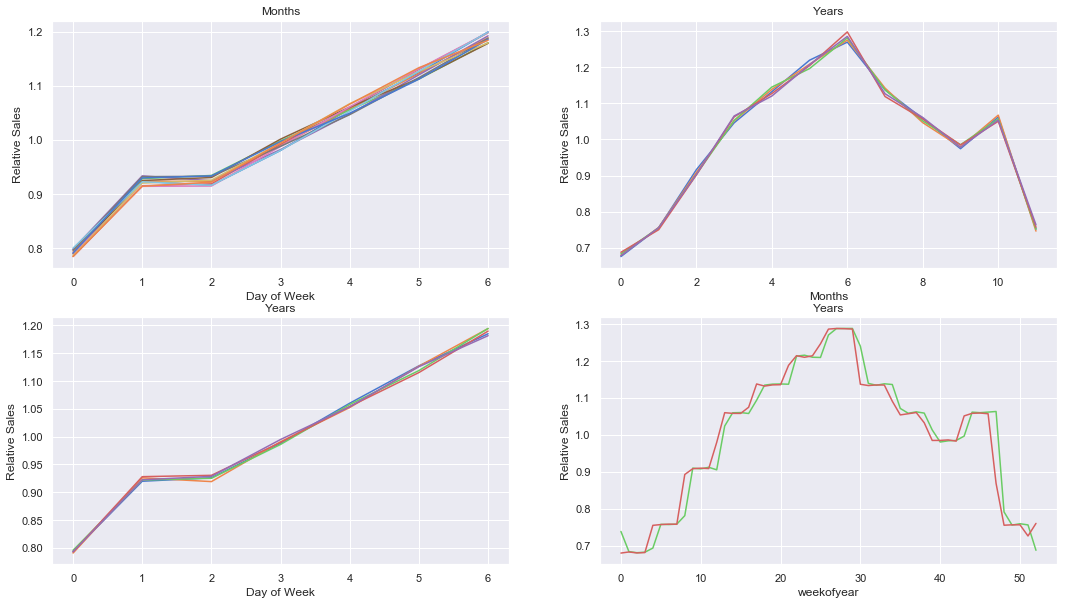

In [11]:
agg_dow_month = pd.pivot_table(data, index='dayofweek', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(data, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(data, index='dayofweek', columns='year',
                              values='sales', aggfunc=np.mean).values

agg_woy_year = pd.pivot_table(data, index='weekofyear', columns='year',
                              values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 10))
plt.subplot(221)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
#plt.legend(loc="best")
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(222)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")
plt.subplot(223)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(224)
plt.plot(agg_woy_year/ agg_woy_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("weekofyear")
plt.ylabel("Relative Sales")
plt.show()

# item-store relationships

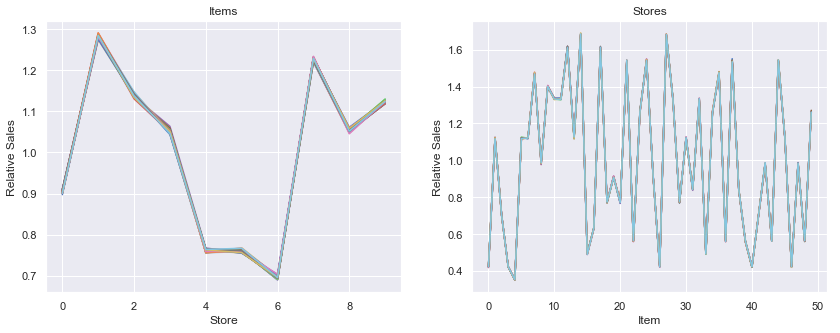

In [12]:
agg_store_item = pd.pivot_table(data, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

# a simply linear regression

item,1,2,3,4,5,6,...,45,46,47,48,49,50
store,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,...,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,...,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,...,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,...,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,...,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,...,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,...,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,...,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,...,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


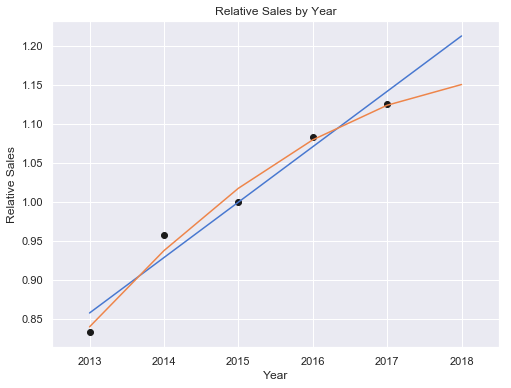

2018 Relative Sales by Degree-1 (Linear) Fit = 1.2132
2018 Relative Sales by Degree-2 (Quadratic) Fit = 1.1509


In [109]:
# Item-Store Look Up Table
store_item_table = pd.pivot_table(data, index='store', columns='item',
                                  values='sales', aggfunc=np.mean)
display(store_item_table)

# Monthly pattern
month_table = pd.pivot_table(data, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= grand_avg

# Day of week pattern
dow_table = pd.pivot_table(data, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= grand_avg

# Day of week pattern by item
dow_table_item = pd.pivot_table(data, index='dayofweek', columns = 'item',values='sales', aggfunc=np.mean)
#print(dow_table_item )
dow_table_item = dow_table_item / dow_table_item.mean(0)

# Yearly growth pattern
year_table = pd.pivot_table(data, index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg

# Week of year pattern
woy_table = pd.pivot_table(data, index='weekofyear', values='sales', aggfunc=np.mean)
woy_table /= grand_avg


years = np.arange(2013, 2019)
annual_sales_avg = year_table.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 2))

plt.figure(figsize=(8,6))
plt.plot(years[:-1], annual_sales_avg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.show()

print(f"2018 Relative Sales by Degree-1 (Linear) Fit = {p1(2018):.4f}")
print(f"2018 Relative Sales by Degree-2 (Quadratic) Fit = {p2(2018):.4f}")

# We pick the quadratic fit
annual_growth = p2

In [110]:
print(dow_table)

              sales
dayofweek          
0          0.792907
1          0.922979
2          0.925708
3          0.989913
4          1.055635
5          1.122725
6          1.189340


## Math
So, the data is not just synthetic. Basically, a sales volume time series for any item and store seems to be generated approximately as 

$TS(item, sales, date) = TS_{base}(date) * c(item, sales) * \eta_1(item, sales, date) + \eta_2(item, sales, date)$,

where 
- $TS_{base}$ is a fixed time series common for all items and stores,
- $c(item, sales)$ is a unique time series multiplier,
- $\eta_1$ and $\eta_2$ are white noise variables.

Now we need to model $TS_{base}$. Judging by what we've seen so far, it can be expressed as

$TS_{base}(date) = trend(year)*seasonality_{weekly}(weekday)*seasonality_{yearly}(month)$.

Thus, to model sales volumes we need to estimate 4 functions: $c(item, sales)$, $trend(year)$, $seasonality_{weekly}(weekday)$ and $seasonality_{yearly}(month)$. Let's do it in the "dumbest" way possible: by averaging data.

$c(item, sales) = average_{date} \, TS(item, sales, date)$

$trend(year) = \frac{average_{item, store, year} \, TS(item, sales, date)}{average_{total} \, TS}$

$seasonality_{weekly}(weekday) = \frac{average_{item, store, weekday} \, TS(item, sales, date)}{average_{total} \, TS}$

$seasonality_{yearly}(month) = \frac{average_{item, store, month} \, TS(item, sales, date)}{average_{total} \, TS}$

Now to make predictions, we simply look up values of $c$, $seasonality$ and $trend$. Okay, there is still one small issue: we have to extrapolate our trend.


In [134]:
def slightly_better(test, submission):
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        #dow, month, year = row['date'].dayofweek, row['date'].month, row['date'].year
        dow, woy, year = row['date'].dayofweek, row['date'].weekofyear, row['date'].year
        item, store = row['item'], row['store']
        base_sales = store_item_table.at[store, item]
        mul = woy_table.at[woy, 'sales'] * dow_table_item.iloc[dow][item]
        pred_sales = base_sales * mul * annual_growth(year)
        #print(year, annual_growth(year) )
        #sys.exit()
        submission.at[row['id'], 'sales'] = pred_sales
    return submission

slightly_better_pred = slightly_better(df_test, sample_sub.copy())
slightly_better_pred.to_csv("sbp_float.csv", index=False)

# Round to nearest integer (if you want an integer submission)
sbp_round = slightly_better_pred.copy()
sbp_round['sales'] = np.round(sbp_round['sales']).astype(int)
sbp_round.to_csv("sbp_round.csv", index=False)